<a href="https://colab.research.google.com/github/Yeonsu-Hong/Aiffel_Daegu_AI_project/blob/master/220118_exp5_Kaggle_contest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# exp5_캐글 경진대회

**# [49] 노드부터가 직접 튜닝해본 데이터!**

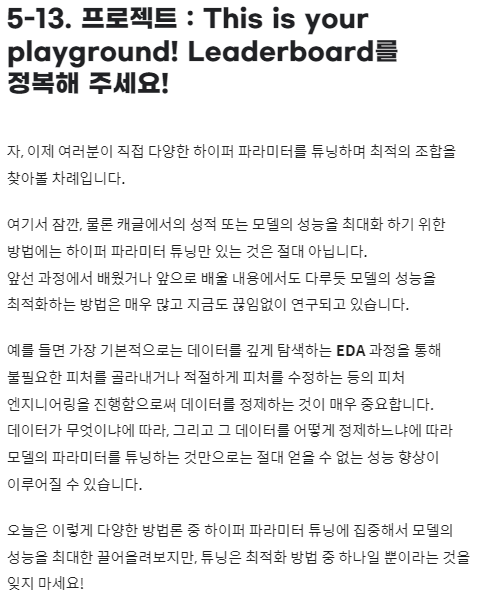

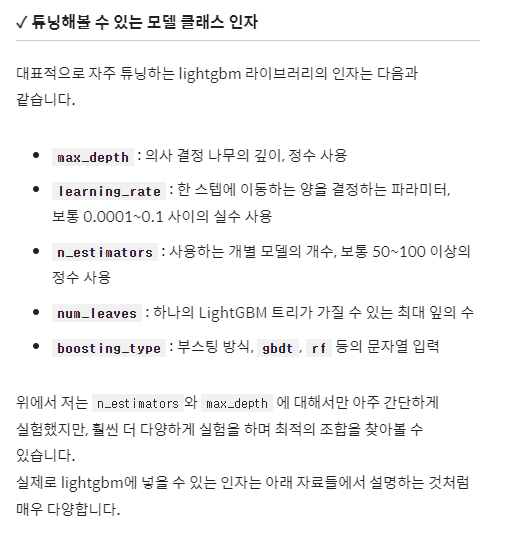

In [1]:
# http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/
# https://injo.tistory.com/48

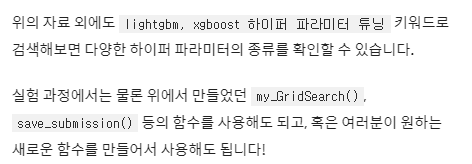

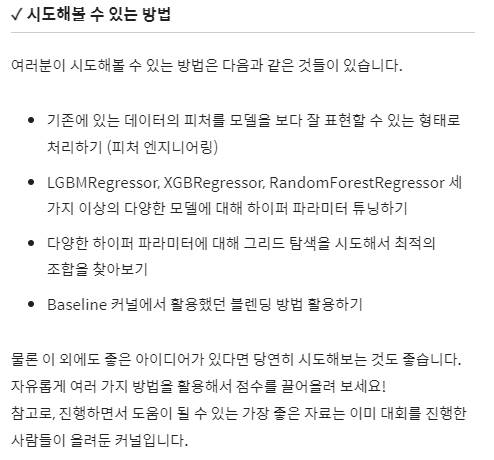

In [ ]:
# https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks

# 위의 대회시 사람들이 올렸던 data들을 참조!

# 우선적으로는 본 exp를 진행하면서 썼던 raw-data들을 전부 쓰고 활용하겠지만, 
# 다양한 모델들의 참조와 공부는 오른쪽 상단에서 가장 득표를 많이 받은 (Most Votes)를 참조하여 진행! 

# 고작 며칠정도의 시간의 제약과 모델들을 한꺼번에 다 공부해서 실험하기에는 무리가 있음!

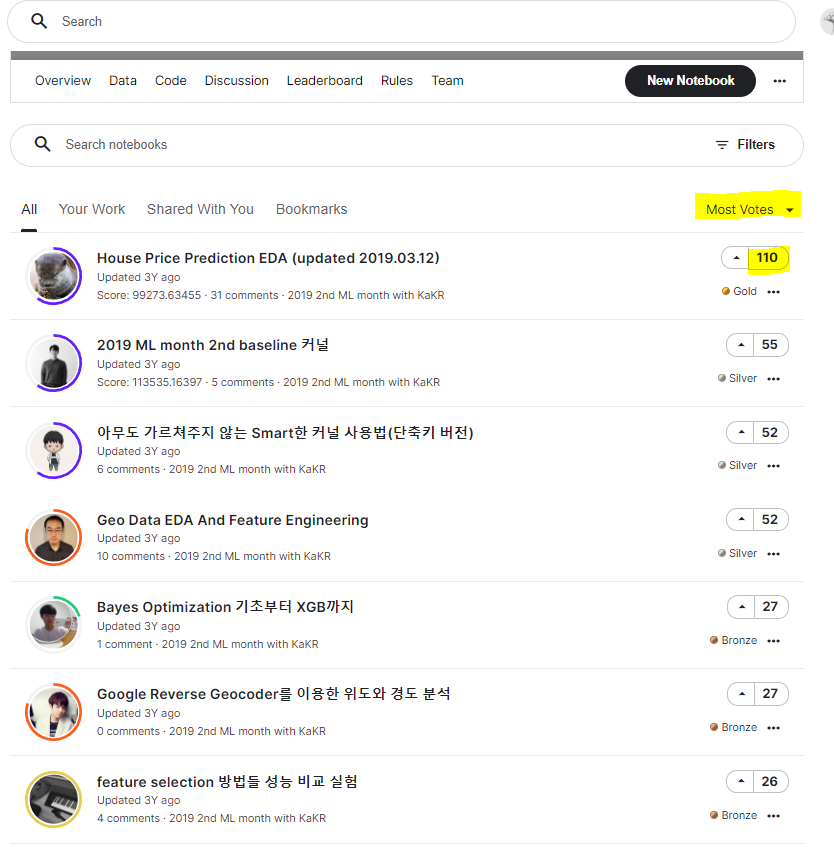

In [2]:
# https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12 

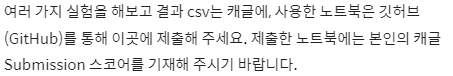

In [ ]:
# 본 코드의 실행은 Colab에서 제출은 csv파일을 Kaggle에 제출하여 score는 스크린샷으로 첨부할 예정!

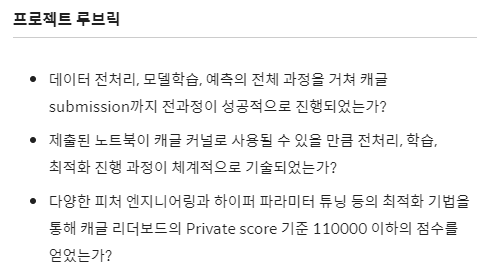

In [ ]:
# 개최되었던 본 대회에서는 
# 1. train.csv라는 모델 학습용 파일
# 2. test.csv라는 테스트용 파일
# 3. sample_submission.csv라는 제출용 파일이 제공된다. (이 파일로 Kaggle에 제출하여 score를 매기게 된다.)

# train.csv를 활용해서 데이터를 뜯어보고 모델을 학습시킨 후,test.csv 파일의 데이터에 대해 Price를 예측해서 
# sample_submission.csv의 형식에 맞는 형태로 캐글에 제출한다.

In [ ]:
# 코랩에서 진행한 것이기 때문에 위의 알집 데이터를 다운로드 받는다.

In [4]:
!mkdir -p ~/aiffel/kaggle_kakr_housing/data
!unzip /root/aiffel/kaggle-kakr-housing-data.zip -d /root/aiffel/kaggle_kakr_housing/data
!ln -s /root/aiffel/kaggle_kakr_housing/data/data/*.csv ~/aiffel/kaggle_kakr_housing/data
!ls ~/aiffel/kaggle_kakr_housing/data # 디렉토리 내 파일 확인

Archive:  /root/aiffel/kaggle-kakr-housing-data.zip
  inflating: /root/aiffel/kaggle_kakr_housing/data/data/sample_submission.csv  
  inflating: /root/aiffel/kaggle_kakr_housing/data/data/test.csv  
  inflating: /root/aiffel/kaggle_kakr_housing/data/data/train.csv  
'*.csv'   data	 sample_submission.csv	 test.csv   train.csv


In [5]:
# 1. Baseline 모델 --> 셋팅하기

In [6]:
# https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline

In [ ]:
# exp 학습에서 사용하였던 그대로의 baseline을 사용한다.
# 여러가지 시행 착오를 거치며 새로운 baseline을 쓸수도 있으나, 통제 변인으로 학습시 나왔던 결과와 비교하여 모델의 성능 평가및 스코어를 내기 위함이다.

# 캐글에서 다운 받은 2019-ml-month-2nd-baseline.ipynb 파일을 사용할 예정인데, 업로드를 해주어야 한다.
# 디렉토리의 위치는 ~/aiffel/kaggle_kakr_housing 폴더를 사용한다. 


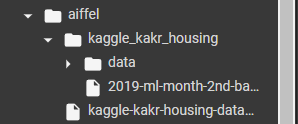

In [7]:
# Baseline이 사용하는 라이브러리를 설치해야 한다.

# 회귀 모델을 구현하는데 사용하는 xgboost, lightgbm 라이브러리
# 그리고 결측 데이터를 확인하는 missingno 라이브러리가 필요하다.

# 보통 아래명령어로 버전까지 맞추어 설치 가능하나 보통은 설치가 되어 있다. 
# !pip list | g rep xgboost 이런식으로 설치가 되었는지 확인해 본다.

# !conda install -c conda-forge xgboost=1.3.3
# !conda install -c conda-forge lightgbm=3.1.1
# !conda install -c conda-forge missingno=0.4.2

In [9]:
!pip list | grep xgboost
!pip list | grep lightgbm
!pip list | grep missingno

xgboost                       0.90
lightgbm                      2.2.3
missingno                     0.5.0


In [10]:
# Jupyer Notebook 파일 실행후 matplotlib 시각화를 위해 실행

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
# 필요한 라이브러리 한꺼번에 가져오기!

import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score 
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Kaggle에서의 Baseline 커널의 코드는
# train_data_path = join('../input', 'train.csv')
# sub_data_path = join('../input', 'test.csv')

# 이지만, Colab이나 LMS에서 사용할 때 알맞은 파일 경로는 다음과 같다.

data_dir = os.getenv("HOME") + '/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv') # 테스트 즉, submission시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)


/root/aiffel/kaggle_kakr_housing/data/train.csv
/root/aiffel/kaggle_kakr_housing/data/test.csv


In [ ]:
# 데이터 살펴보기 

# 각 변수들의 정보를 읽어 본다.
# 어떤 데이터를 살리고 없앨지 파악할수 있는 기본정보라서 중요하다.

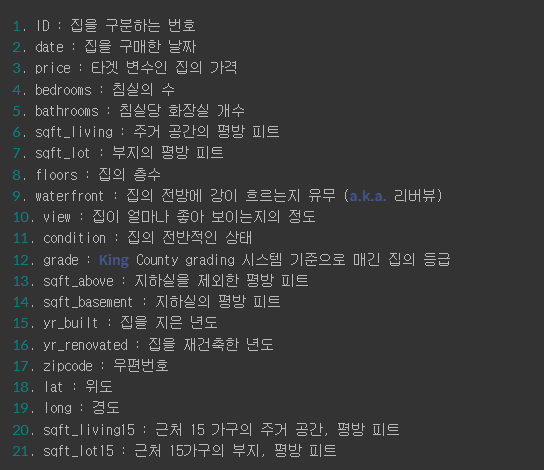

In [14]:
# 데이터 불러오기

data = pd.read_csv(train_data_path) # 학습 데이터 불러오기
sub = pd.read_csv(sub_data_path) # 테스트 데이터 불러오기
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

# 테스트 데이터는 우리가 맞추어야 할 집의 가격, price가 없기 때문에 컬럼이 하나 적은 20이다.

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [15]:
# 학습 데이터에서 라벨 제거하기
# 구하고자 하는 Price 컬럼은 y라는 변수에 저장한 후 해당 컬럼을 지운다.

y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [16]:
# 학습 데이터와 테스트 데이터 합치기

# 모델을 학습 시키기 전에, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 pd.concat으로 합친다.

# 모델 학습을 진행할 때에는 다시 분리해서 사용해야 하기 때문에 데이터를 합치기 전 train_len에 training data의 개수를 저장해서 추후에 학습 데이터만 불러올수 있는 인덱스로 사용

train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [17]:
data.head() # 데이터 상단 5줄 확인하는 코드

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [18]:
data.tail() # 데이터 하단 5줄 확인하는 코드

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [19]:
# 3번째 열의 date data 같은 경우에는 년월까지 처리하여 시각화 시키는작업이 필요할꺼 같다.

In [20]:
# 간단한 전처리

# missingno 라이브러리를 통해서 결측치 데이터( 비어있는 쓸모없는 정크 데이터)는 삭제하는 것이 좋을것 같다.
# 그 전에 시각화!

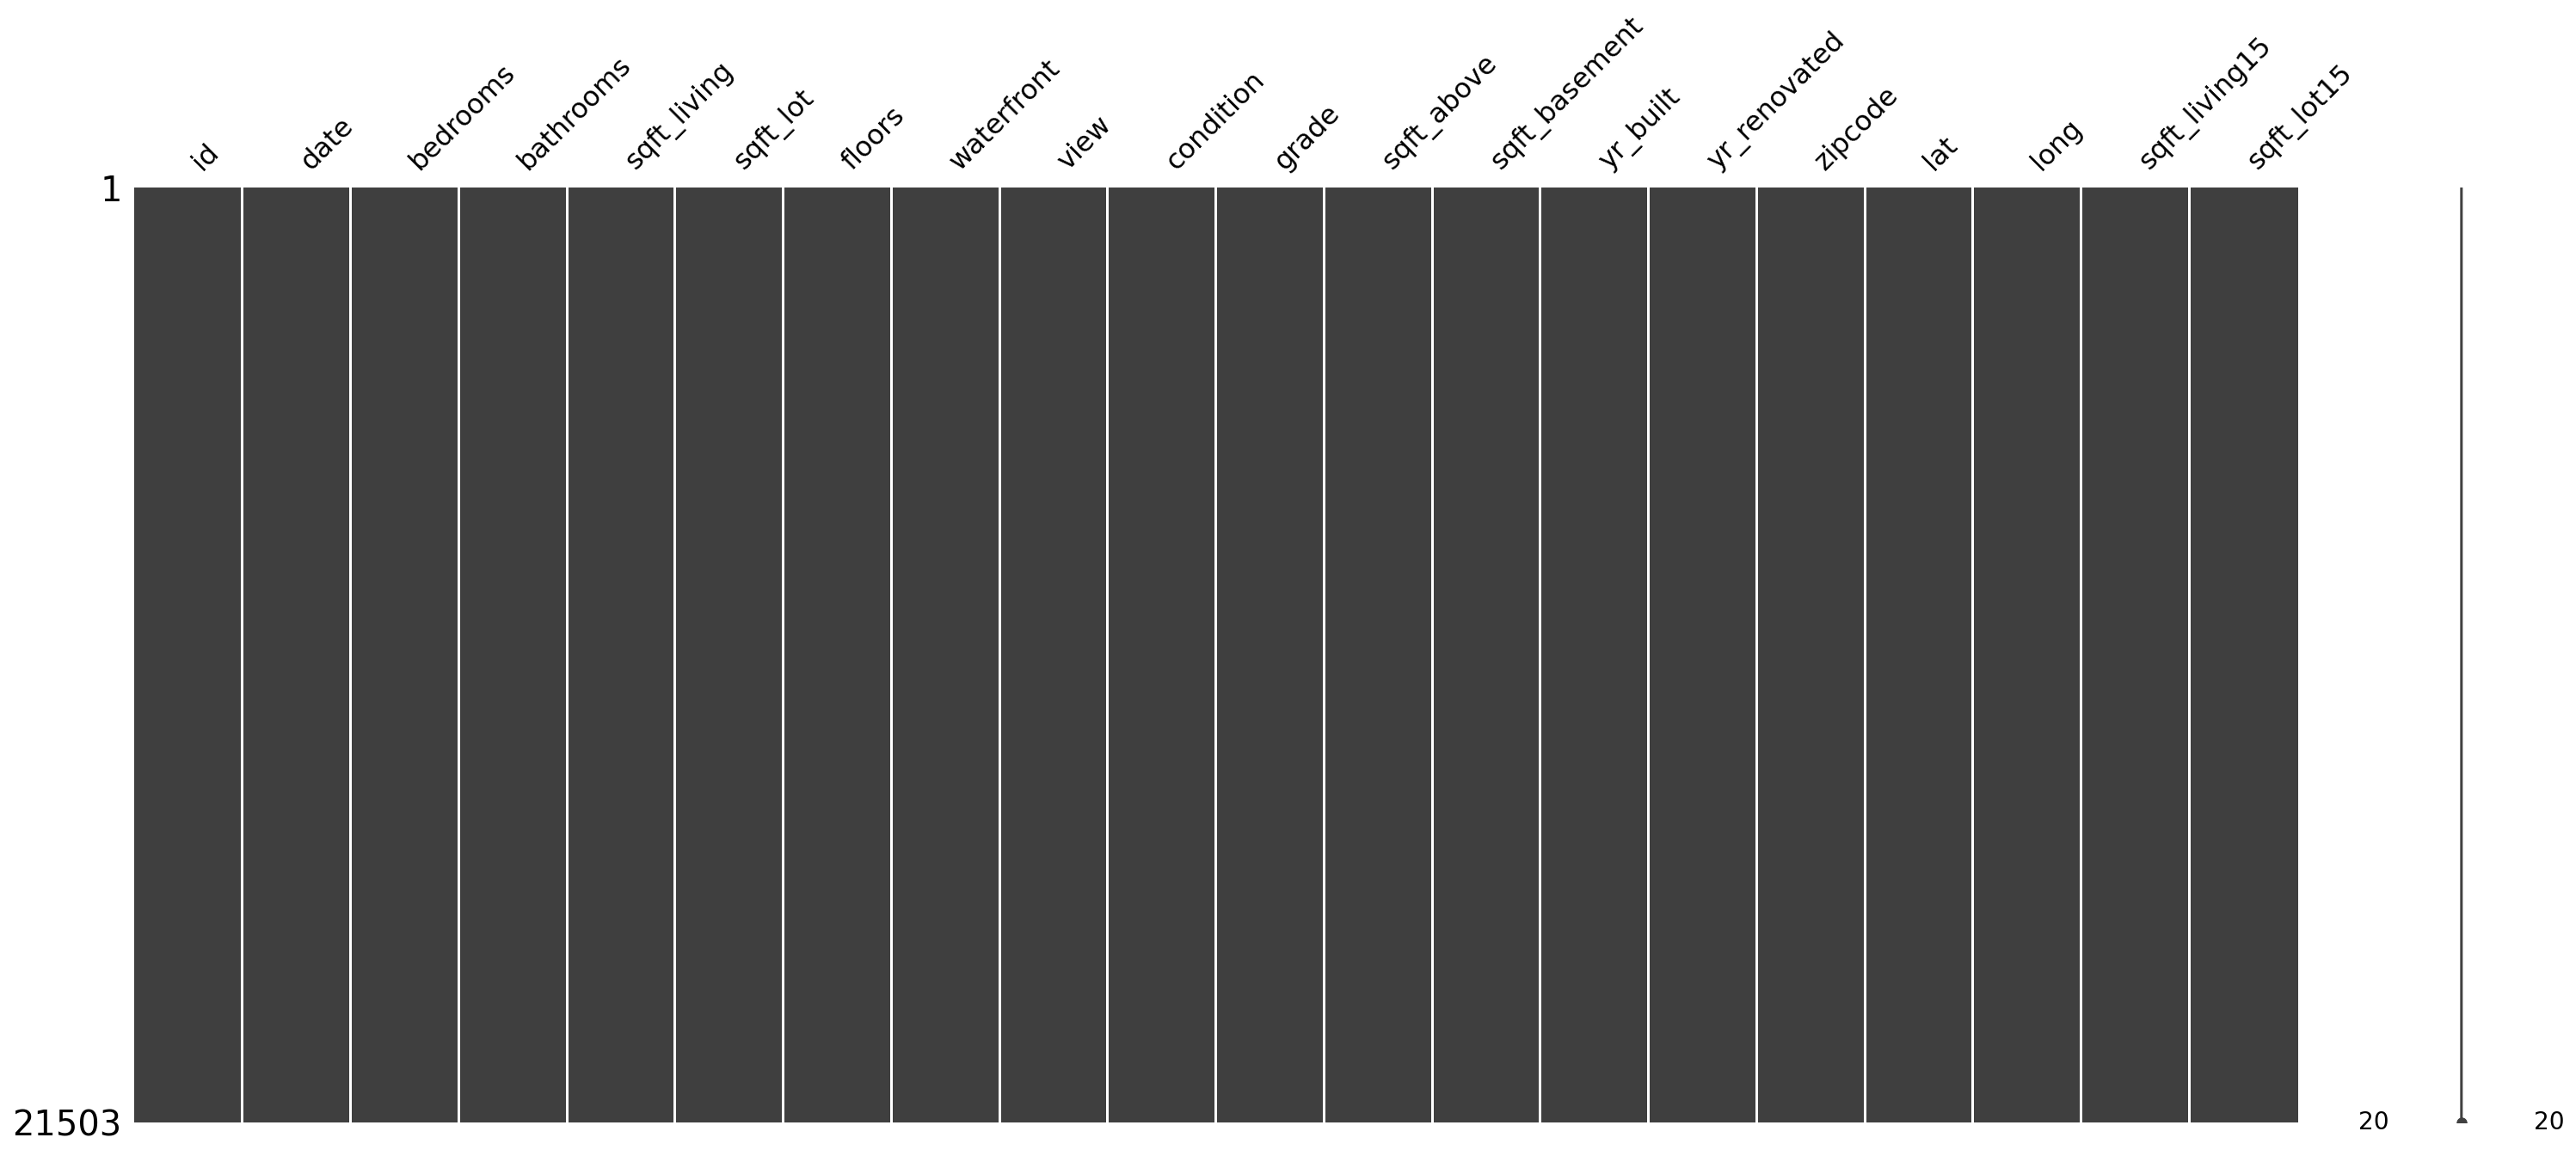

In [22]:
msno.matrix(data)

In [23]:
# DataFrame을 매트릭스 모양 그대로 시각화 한 것이다.
# 만약 특정 row, col에 NaN라는 결측치가 있었다면 해당 부분이 하양게 나온다.
# 결측치가 없다면, 매트릭스 전체가 까맣게 나온다.

In [24]:
# 좀더 세분화하여 3단계

# 1. id컬럼이 결측치인지 확인한다.
# 2. 결측치인 데이터만 뽑아낸다.
# 3. 결측치인 데이터의 개수를 카운팅.

In [25]:
# 1. id 컬럼이 결측치인지 확인한다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [26]:
# 2. 결측치인 데이터만 뽑아 낸다.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [ ]:
# -> 결측치가 없다.

In [27]:
# 3. 결측치인 데이터의 개수 카운팅.
print('{}: {}'.format('id', len(null_data.values)))

id: 0


In [28]:
# 필요없는 id 컬럼을 제거!
# 예측 결과를 제출할 때를 대비하여 sub_id 변수에 id컬럼을 저장해두고 지우기

sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [29]:
# 앞 19번 노드에서 언급했던것처럼 년월로 정리 (람다 함수를 이용!)
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [30]:
# 각 변수들의 분포 확인

# 너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는 데에 좋지 않은 영향을 미치므로 다듬는 작업을 한다.

# 시각화 코드를 통해 id 컬럼을 제외한 19개 컬럼에 대해 한 번에 모든 그래프를 그린다.
# 10행 2열의 subplot에 그래프를 그리기 위해 2중 for문을 사용
# 그래프는 seaborn에 있는 kdeplot을 사용


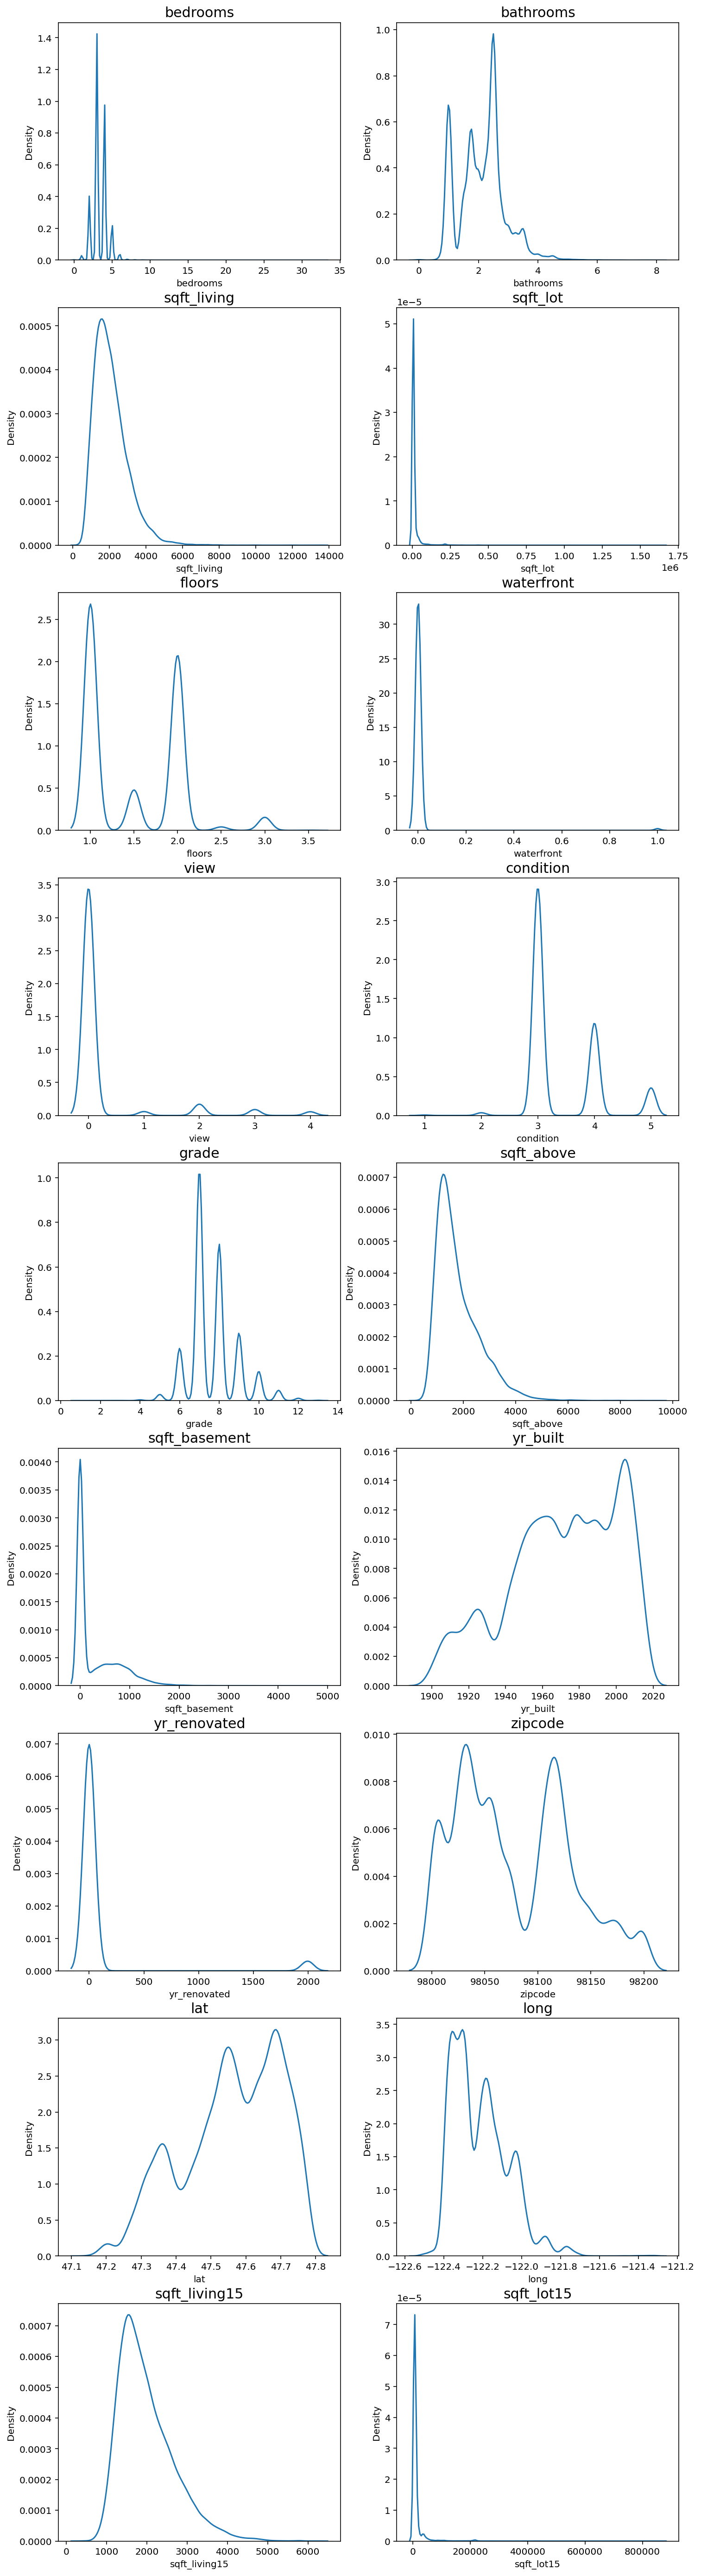

In [31]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))    

# id 변수(count==0인 경우)는 제외하고 분포를 확인.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [ ]:
# 그래프 분포상  bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 편차가 크다.

# 이렇게 한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있다.

# 아래와 같이 치우친 컬럼들을 skew_columns 리스트 안에 담고, 모두 np.log1p()를 활용해서 로그 변환을 해주도록 함. numpy.log1p() 함수는 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수다.


In [34]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15', 'waterfront']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

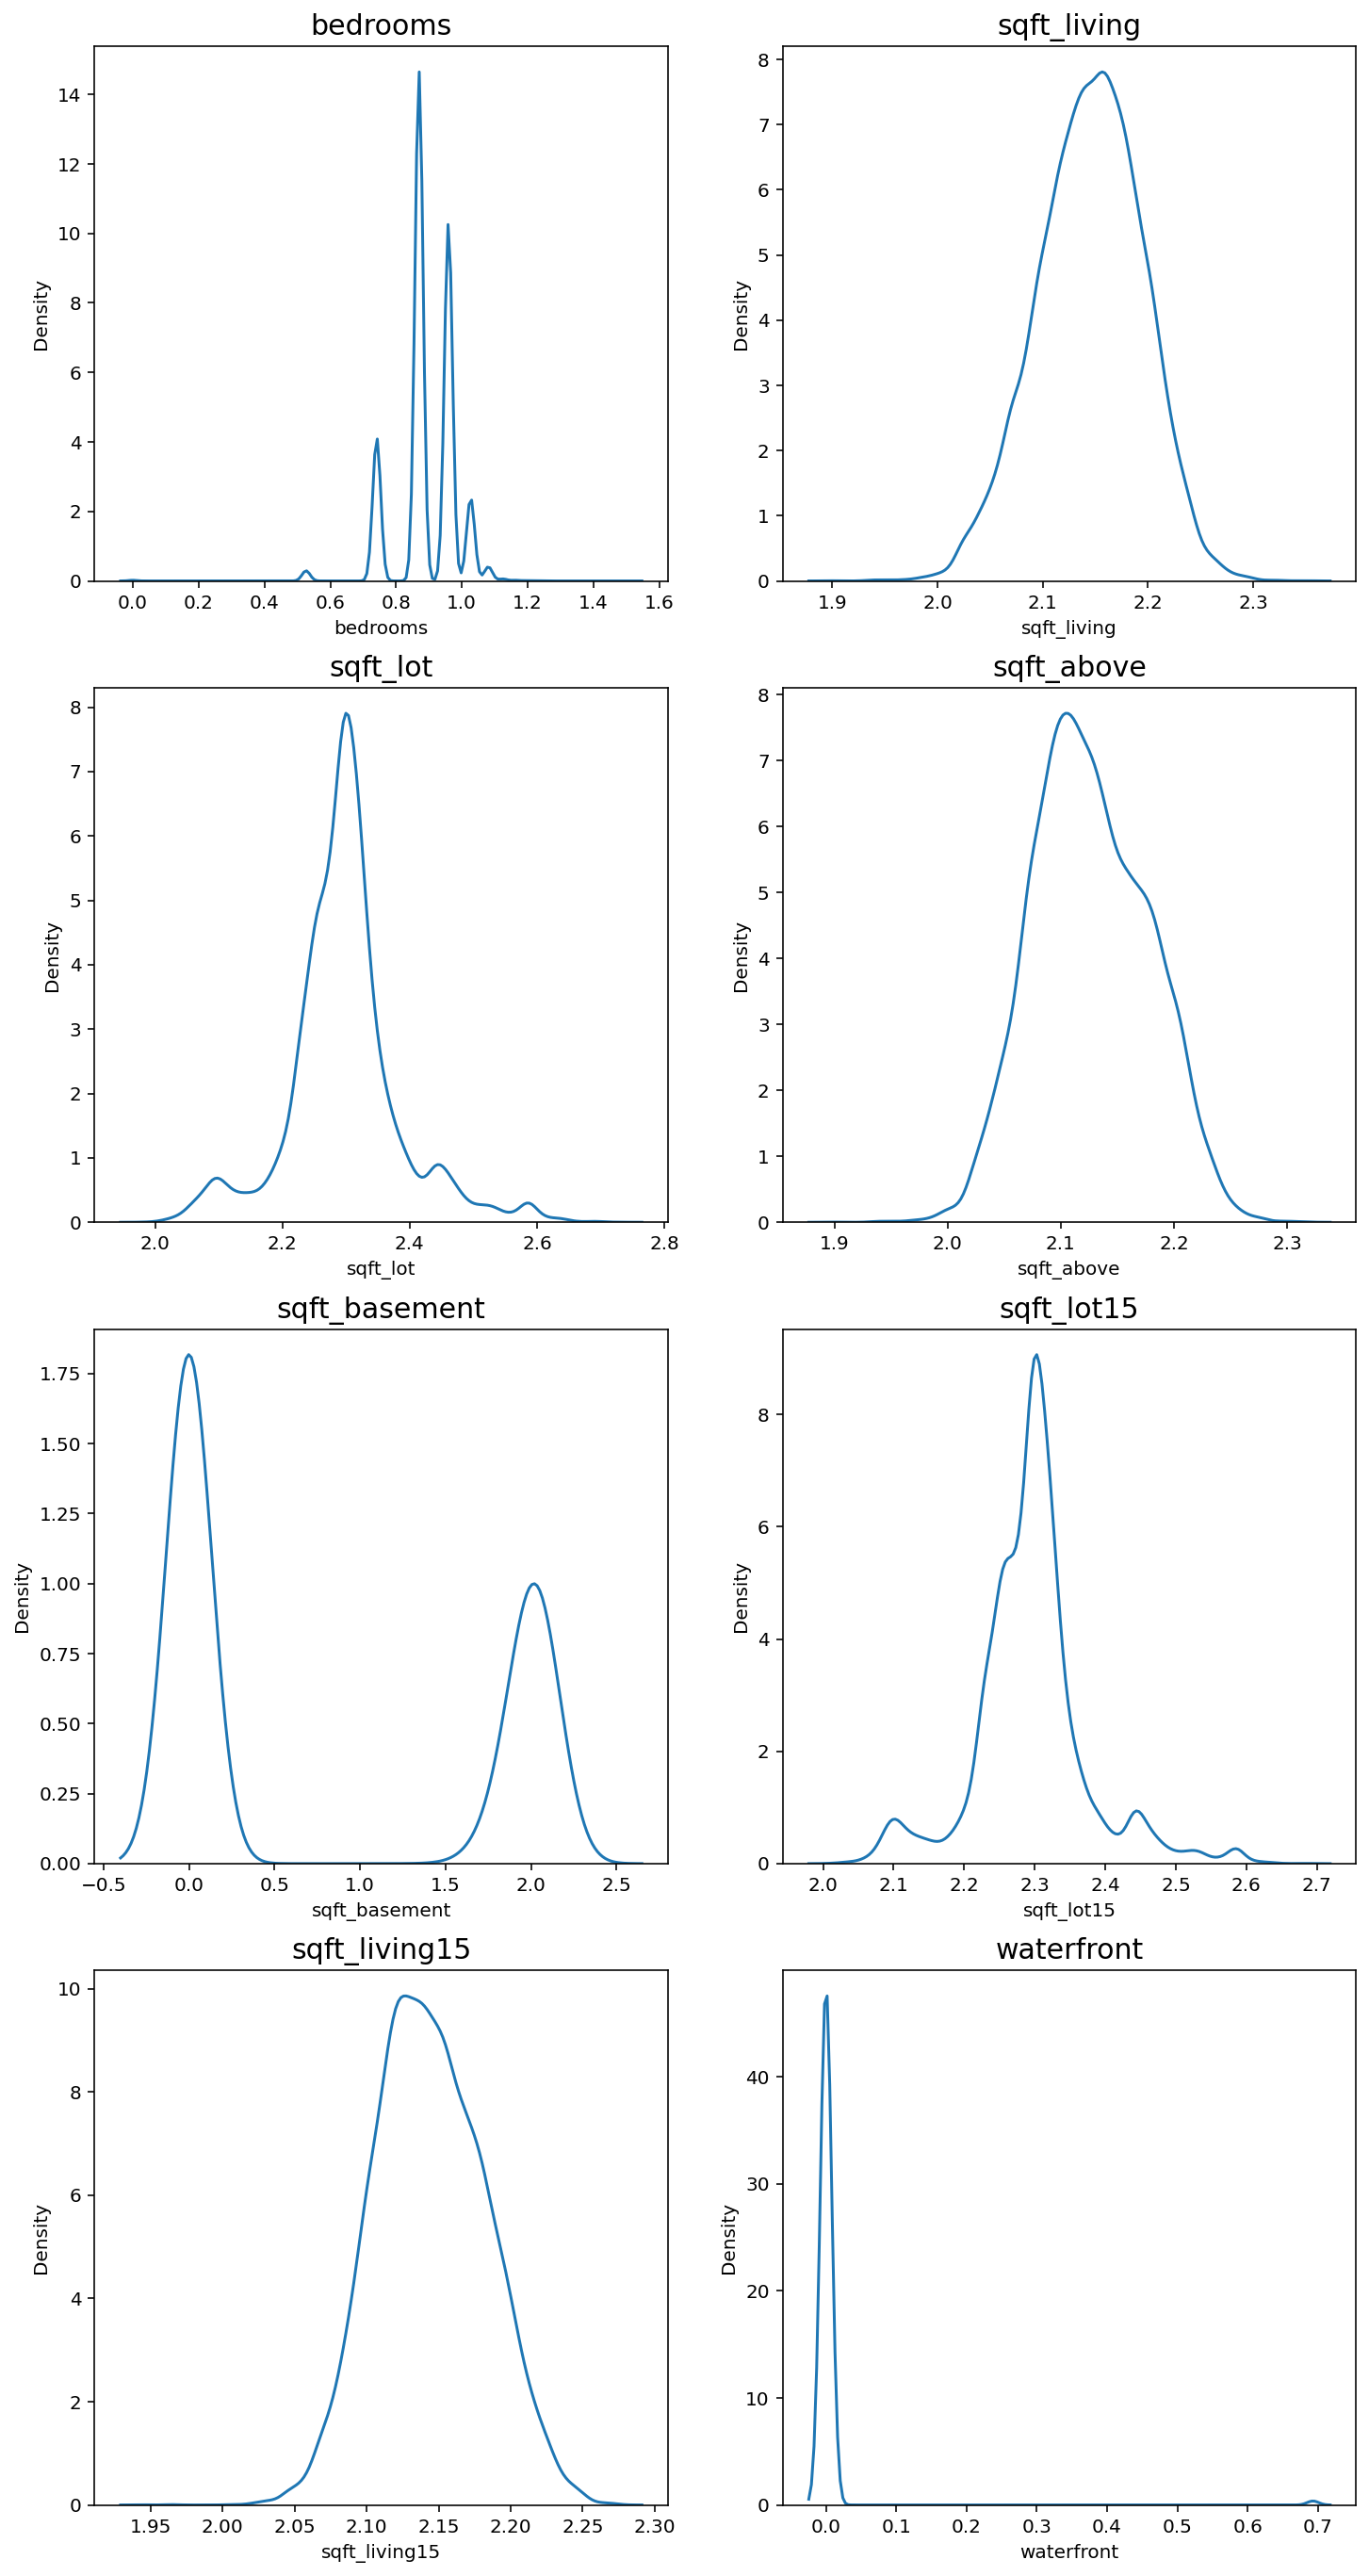

In [35]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 8:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [36]:
# waterfront 같은 경우에는 편차가 심해 보여서 데이터를 따로 넣어서 변환 했으나, 그대로였다.

# 찾아보니, 9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
# 모든 데이터에서 강이 흐르는 유무는 없었다. 데이터를 변환하는거 자체가 무의미하다

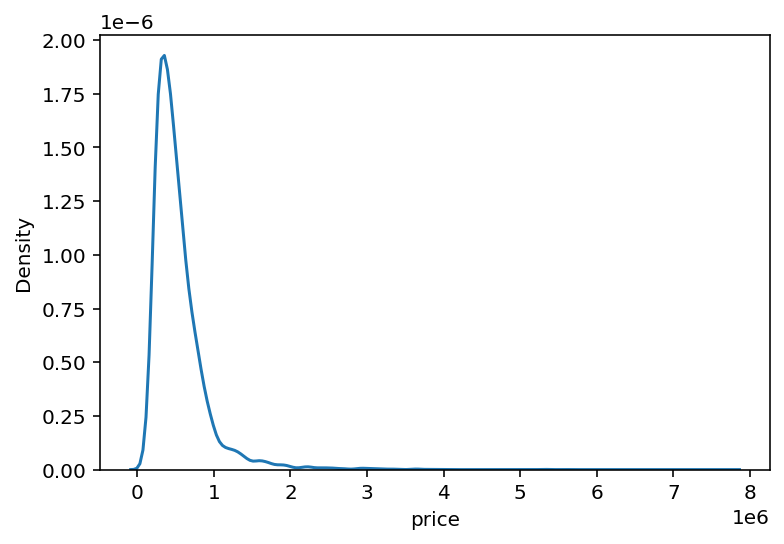

In [37]:
# 맞추어야할 집의 가격 즉, data[price]의 분포를 로그 변환했을때 결과!

sns.kdeplot(y)
plt.show()

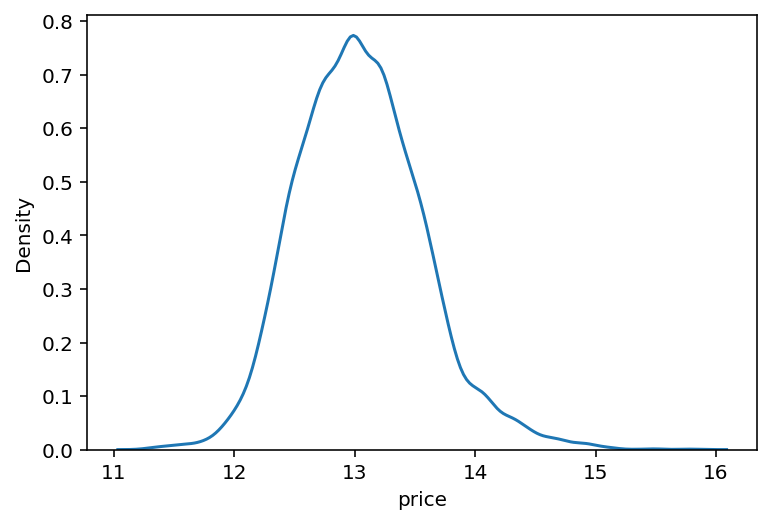

In [38]:
# 로그 변환을 취하여, 0에 가깝게 몰려있는 데이터들은 넓게 퍼뜨리고, 매우 크게 퍼져있는 소우의 데이터들은 작은 y값으로 모이게 한다.

y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [39]:
# 합쳐져 있던 전체 데이터를 다시 나누어준다.

# 저장해두었던 train_len을 인덱스로 활용해서 :train_len까지는 학습 데이터 -> x 변수에 저장
# train_len: 부터는 실제로 추론을 해야하는 테스트 데이터 즉 sub 변수에 저장

sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [40]:
# 여러가지 모델의 결과를 산술평균하여 블렌딩 모델을 만든다. 
# 블렌딩 기법은 앙상블 기법이라고도 한다.

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [41]:
# 교차 검증을 통해 모델의 성능을 간단히 평가!

def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values) # 5폴드 교차 검증을 한다.
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
# 교차 검증은 안정적인 검증 점수를 얻고 훈련에 더 많은 데이터를 사용할 수 있다.


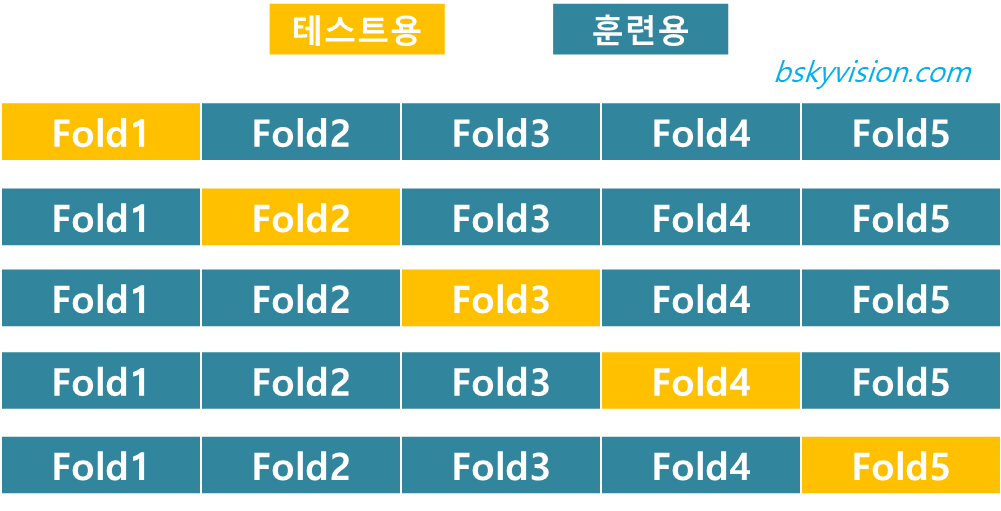

In [42]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
[13:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:48:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:48:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:48:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost, CV score:0.8624
Model: LightGBM, CV score:0.8819


In [43]:
# submission 파일 만들기

# cross_val_score() 함수는 회귀모델을 전달할 경우 R^2 점수를 반환한다.
# R^2값은 1에 가까울수록 모델이 잘 학습되었다는 것을 의미!

In [44]:
# 각 모델에 대한 예측 결과를 평균 내어주는 AveragingBlending()함수를 만들어 사용.
# 이 함수는 models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤 predictions에 그 예측 결괏값을 모아서 평균한 값을 반환!

def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [45]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[13:55:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


array([ 562566.39221578,  389660.68147617, 1340643.45409443, ...,
        438058.69137012,  345498.01852609,  414241.23776683])

In [46]:
# sample_submission.csv 확인

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [47]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.625664e+05
1,15036,3.896607e+05
2,15037,1.340643e+06
3,15038,3.317573e+05
4,15039,2.966855e+05


In [48]:
# submission.csv 파일을 저장!

my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/root/aiffel/kaggle_kakr_housing/data/submission.csv


In [ ]:
# https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr
# 대회 링크에 제출

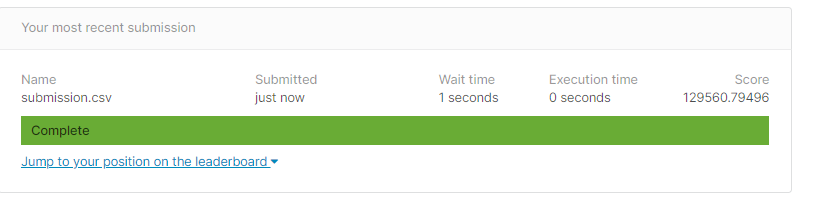

In [49]:
# 프로젝트 루브릭의 세번째 충족요건인 110000이하의 Score가 미치지 않아서 여러가지 하이퍼 파라미터를 튜닝하여 개선할 필요가 있다.

In [ ]:
# 다시 재수정하기.

In [ ]:
# 데이터 다시 준비

In [ ]:
# 위에서 확인 했던 https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12
# 가장 득표가 많이 되었던 집값 예측 코드였다.

# 시각화와 여러가지 그래디언트 부스팅 라이브러리를 사용해서 나타내었다.

# 모델을 import (4가지 모델!)

# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# 위에서 import한 라이브러리인데, 
# XGboost나 LIghtgbm을 가장 많이 사용한다.

# 하지만, 튜닝해서 확인할 인자로 Lightgbm을 써서 확인해보고자 한다.
# 시간적 제약으로 인해서...

# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [1, 10],
#     'learning_rate': [0.05, 0.1]                # 추가한 내용 : 기본값은 0.1인데 또 optimizer마다의 기본값이 다르다.
#     'num_leaves': [1, 10000]                 # depth가 10이라면 10000 - 1 = 9999가 트리가 가질수 있는 최대 잎사귀수이다.
# }

# 윗 부분에서 learing_rate와 num_leaves를 추가하여 진행해 보았다.

In [129]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [130]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [131]:
# date값 수정
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [132]:
# 타깃 데이터인 price 컬럼 (따로 y 변수에 저장후 삭제)
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [133]:
# 필요없는 id 컬럼까지 삭제

del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [134]:
# test 데이터에 대해서도 같은 작업을 진행!

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [135]:
# 타깃 데이터 y의 확인!
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

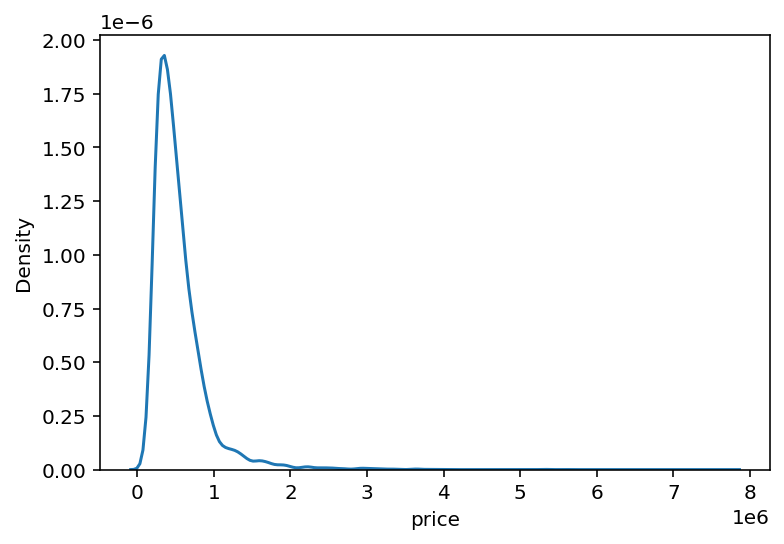

In [136]:
# 데이터 분포 확인!
sns.kdeplot(y)
plt.show()

In [59]:
# 편차가 치우쳐져 있어서 y는 np.log1p()함수를 통해 로그 변환을 해주고, 나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용하여 되돌림
# np.exp1m()은 np.log1p()와는 반대로 각 원소 x마다 exp(x)-1의 값을 반환해 준다.

In [137]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

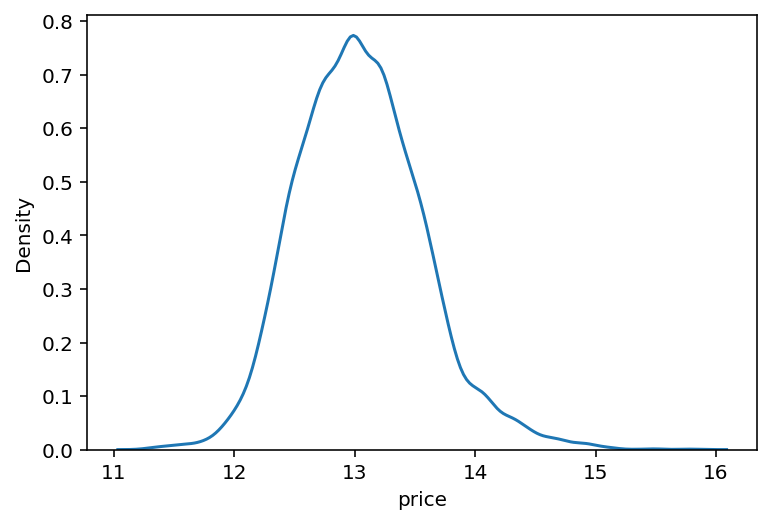

In [138]:
sns.kdeplot(y)
plt.show()

In [139]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [140]:
# 개선을 모델 튜닝!
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # mean_squared_error 같은 경우에는 점수를 계산하기 위해 필요!

# 주의해야 할 것은 ,y_test나 y_pred는 위에서 np.log1p()로 변화이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다.

# exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE값을 얻을 수 있다.

In [141]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [142]:
# 모델을 import (4가지 모델!)

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [143]:
random_state=2022        # random_state값 고정! (매번 변하는 불확실성 제거를 위해서, 동일한 결과를 보고 싶다.)

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [144]:
# class의 __name__ 속성에 접근해서 이름 얻기
gboost.__class__.__name__
# xgboost.__class__.__name__
# lightgbm.__class__.__name__
# rdforest.__class__.__name__

'GradientBoostingRegressor'

In [145]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

# 실제 정답과 예측한 값의 차이의 제곱을 평균한 값의 제곱근이다.

[15:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 130361.23368538941,
 'LGBMRegressor': 120099.06723661404,
 'RandomForestRegressor': 135139.59142571784,
 'XGBRegressor': 132088.01930383555}

In [146]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [147]:
# 하이퍼 파라미터로 테스트 진행!
from sklearn.model_selection import GridSearchCV

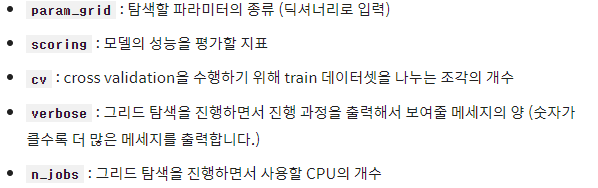

In [149]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'learning_rate': [0.05, 0.1],                # 추가한 내용 : 기본값은 0.1인데 또 optimizer마다의 기본값이 다르다.
    'num_leaves': [1, 10000]                 # depth가 10이라면 10000 - 1 = 9999가 트리가 가질수 있는 최대 잎사귀수이다.
}                                            # 값들을 극단에서의 비교를 통해서 눈으로 직접확인해보고 learing_rate가 0.05(작은것)과 num_leaves가 10000인것으로 selection할 근거를 얻는 것이 목표이다.

In [150]:
# LightGBM 모델 사용
model = LGBMRegressor(random_state=random_state)


In [151]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2022), n_jobs=5,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [1, 10],
                         'n_estimators': [50, 100], 'num_leaves': [1, 10000]},
             scoring='neg_mean_squared_error', verbose=1)

In [152]:
grid_model.cv_results_

{'mean_fit_time': array([0.052914  , 2.2157248 , 0.03609219, 2.00623016, 0.03199115,
        6.73223591, 0.03137617, 9.65838699, 0.03710446, 1.07001514,
        0.02857547, 1.21616807, 0.0324399 , 5.84197998, 0.05074396,
        8.38101974]),
 'mean_score_time': array([0.        , 0.02140255, 0.        , 0.03243327, 0.        ,
        0.08307681, 0.        , 0.16134429, 0.        , 0.02630339,
        0.        , 0.02975154, 0.        , 0.10398626, 0.        ,
        0.09921937]),
 'mean_test_score': array([        nan, -0.10455588,         nan, -0.07410433,         nan,
        -0.03252692,         nan, -0.02812993,         nan, -0.07339447,
                nan, -0.05502043,         nan, -0.02827065,         nan,
        -0.02776233]),
 'param_learning_rate': masked_array(data=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1,
                    0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False, False, False,
                    Fal

In [153]:
params = grid_model.cv_results_['params'] # 파라미터 조합 여라가지가 뜬다.
params

[{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 50, 'num_leaves': 1},
 {'learning_rate': 0.05,
  'max_depth': 1,
  'n_estimators': 50,
  'num_leaves': 10000},
 {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100, 'num_leaves': 1},
 {'learning_rate': 0.05,
  'max_depth': 1,
  'n_estimators': 100,
  'num_leaves': 10000},
 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 50, 'num_leaves': 1},
 {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 50,
  'num_leaves': 10000},
 {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 100,
  'num_leaves': 1},
 {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 100,
  'num_leaves': 10000},
 {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50, 'num_leaves': 1},
 {'learning_rate': 0.1,
  'max_depth': 1,
  'n_estimators': 50,
  'num_leaves': 10000},
 {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100, 'num_leaves': 1},
 {'learning_rate': 0.1,
  'max_depth': 1,
  'n_estimators': 100,
  'n

In [154]:
score = grid_model.cv_results_['mean_test_score'] # 각 조합에 대한 점수
score

array([        nan, -0.10455588,         nan, -0.07410433,         nan,
       -0.03252692,         nan, -0.02812993,         nan, -0.07339447,
               nan, -0.05502043,         nan, -0.02827065,         nan,
       -0.02776233])

In [155]:
results = pd.DataFrame(params)
results['score'] = score

results

,learning_rate,max_depth,n_estimators,num_leaves,score
0,0.05,1,50,1,NaN
1,0.05,1,50,10000,-0.104556
2,0.05,1,100,1,NaN
3,0.05,1,100,10000,-0.074104
4,0.05,10,50,1,NaN
5,0.05,10,50,10000,-0.032527
6,0.05,10,100,1,NaN
7,0.05,10,100,10000,-0.028130
8,0.10,1,50,1,NaN
9,0.10,1,50,10000,-0.073394


In [80]:
# GridSearchCV 외에 다양한 점수 체계를 사용할 수 있다.

In [156]:
# 음수값 변환
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSE
0,0.05,1,50,1,NaN,NaN
1,0.05,1,50,10000,-0.104556,0.323351
2,0.05,1,100,1,NaN,NaN
3,0.05,1,100,10000,-0.074104,0.272221
4,0.05,10,50,1,NaN,NaN
5,0.05,10,50,10000,-0.032527,0.180352
6,0.05,10,100,1,NaN,NaN
7,0.05,10,100,10000,-0.028130,0.167720
8,0.10,1,50,1,NaN,NaN
9,0.10,1,50,10000,-0.073394,0.270914


In [157]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
0,0.05,1,50,1,NaN,NaN
1,0.05,1,50,10000,-0.104556,0.323351
2,0.05,1,100,1,NaN,NaN
3,0.05,1,100,10000,-0.074104,0.272221
4,0.05,10,50,1,NaN,NaN
5,0.05,10,50,10000,-0.032527,0.180352
6,0.05,10,100,1,NaN,NaN
7,0.05,10,100,10000,-0.028130,0.167720
8,0.10,1,50,1,NaN,NaN
9,0.10,1,50,10000,-0.073394,0.270914


In [116]:
# 위에서 보았던 10만 단위의 RMSE와는 값의 크기가 아주 다른 것
# 이유는 price에 있다. price의 분포의 편차가 치우쳐져 있는 것을 보고 log 변환을 했다.
# 그 후 RMSE 값을 계산하기 위한 함수에서는 np.expm1 함수를 활용해 다시 원래대로 복원한 후 RMSE 값을 계산.

# 하지만 그리드 탐색을 하면서는 np.expm1()으로 변환하는 과정이 없었기 때문에 log 변환되어 있는 price 데이터에서 손실함수 값을 계산한 것이다.


In [158]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
0,0.05,1,50,1,NaN,NaN
1,0.05,1,50,10000,-0.104556,0.323351
2,0.05,1,100,1,NaN,NaN
3,0.05,1,100,10000,-0.074104,0.272221
4,0.05,10,50,1,NaN,NaN
5,0.05,10,50,10000,-0.032527,0.180352
6,0.05,10,100,1,NaN,NaN
7,0.05,10,100,10000,-0.028130,0.167720
8,0.10,1,50,1,NaN,NaN
9,0.10,1,50,10000,-0.073394,0.270914


In [159]:
# RMSLE가 낮은 순서대로 정렬하기
results = results.sort_values('RMSLE')
results

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
15,0.10,10,100,10000,-0.027762,0.166620
7,0.05,10,100,10000,-0.028130,0.167720
13,0.10,10,50,10000,-0.028271,0.168139
5,0.05,10,50,10000,-0.032527,0.180352
11,0.10,1,100,10000,-0.055020,0.234564
9,0.10,1,50,10000,-0.073394,0.270914
3,0.05,1,100,10000,-0.074104,0.272221
1,0.05,1,50,10000,-0.104556,0.323351
0,0.05,1,50,1,NaN,NaN
2,0.05,1,100,1,NaN,NaN


In [160]:
# 함수화 시키기
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [161]:
# my_GridSearch()함수로 간단한 그리드 탐색을 진행
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'learning_rate': [0.05, 0.1],                # 추가한 내용 : 기본값은 0.1인데 또 optimizer마다의 기본값이 다르다.
    'num_leaves': [1, 10000]                 # depth가 10이라면 10000 - 1 = 9999가 트리가 가질수 있는 최대 잎사귀수이다.
}        

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
15,0.10,10,100,10000,-0.027762,0.166620
7,0.05,10,100,10000,-0.028130,0.167720
13,0.10,10,50,10000,-0.028271,0.168139
5,0.05,10,50,10000,-0.032527,0.180352
11,0.10,1,100,10000,-0.055020,0.234564
9,0.10,1,50,10000,-0.073394,0.270914
3,0.05,1,100,10000,-0.074104,0.272221
1,0.05,1,50,10000,-0.104556,0.323351
0,0.05,1,50,1,NaN,NaN
2,0.05,1,100,1,NaN,NaN


In [ ]:
# 가장 좋은 조합은 max_depth=10, n_estimators=100, learning_rate = 0.1, num_leaves = 10000인 model이다.

# 예상대로 나왔다.

# http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/

# -> 위의 site에서 정말 많은 영향을 미치는 파라미터 들이 존재했으나, 시간적 제약으로 다 해보지는 못했다.

# 해당 모델로 학습을 해서 예측값인 submission.csv파일을 만들어서 제출

In [162]:
model = LGBMRegressor(max_depth=10, n_estimators=100,learning_rate = 0.1, num_leaves = 10000, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.07225703, 13.17137396, 14.1308708 , ..., 13.07527645,
       12.62735922, 13.00578304])

In [163]:
# expm1을 통해서 원래 scale로 반환
prediction = np.expm1(prediction)
prediction

array([ 475563.1352215 ,  525114.73010242, 1370752.03109768, ...,
        477001.23209836,  304783.18693158,  444978.29780797])

In [164]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [165]:
# 예측값 덮어 씌우기
submission['price'] = prediction
submission.head()


,id,price
0,15035,4.755631e+05
1,15036,5.251147e+05
2,15037,1.370752e+06
3,15038,2.929942e+05
4,15039,3.296294e+05


In [166]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/root/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [167]:
# 함수로 한방에 정리!
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [168]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/root/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


In [169]:
# 최종적으로 모델 평가를 진행!

# https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

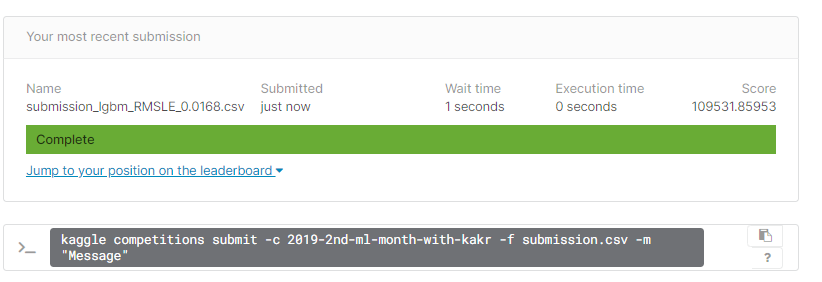

In [ ]:
# score 109531.85953 으로 110000이하 점수를 얻었다.

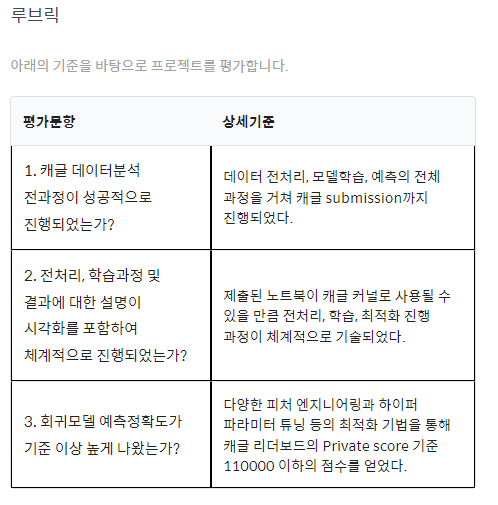

## 총평 : 
루브릭 테이블의 3가지 평가기준을 전부 진행하였다.

사실 첫번째 평가문항에서의 

데이터 전처리, 모델학습, 예측 전제 모두 파이썬의 중급이상의 실력과 DB 라이브러리인 pandas를 잘다루는 것이 필요하다. 

모델 학습 역시 어떠한 히스토그램 기반 그레디언트 부스팅 알고리즘을 구현한 라이브러리가 어떠한 것이 있고 언제 적재적소에 사용할수 있는지 아는 것이 중요하다.

RMSE 같은 경우에도 수학적으로 어떻게 오차를 구하는지 알아야할 부분이다.

그리고 시각화 시키는 라이브러리 seaborn이나 Matplotlib의 사용도 너무나 중요하다. 왜냐하면 적절한 모델인지 예측이 제대로 되었는지는 수치보다 한눈에 볼수 있는 시각화가 강력한 툴이기 때문이다.

예측 정확도가 110000이하 인것은 고무적이지만, 각자 라이브러리에서 다른 다양한 파라미터들을 모두 사용해서 스코어를 더 낮출수 있었으나 시간적인 부분과 여러 일들을 더 이상 미룰수가 없어 여기까지 진행한 부분은 너무나도 아쉽다.

learning_rate와 num_leaves 값을 조정했으나,

추가적으로 중요하다가 보이는 반복량(num_iterations)과 

부스팅 방법 

- XGBoost에서는 gblinear / gbtree / dart 지원

- lightGBM에서는 rf (랜덤포레스트) / gbdt (Gradient Boosted Decision Trees) / dart (드랍아웃 Regression Trees) / goss (Gradient-based One-Side Sampling)을 쓴다.

을 추가하고 싶었다.

경우의 수가 많아지지만, 꼭 한번 exploration 제출과는 예외로 해보면서 익혀야 할 부분이라고 생각한다.

